In [14]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.linalg import det
from scipy.linalg import block_diag
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [316]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
v0=freqs[23]
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")*1e4
ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

fgds=ff+sync/1e6
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
*_,noise_binned= bin_spectra(cl_noise, 10)
*_, fgds_binned= bin_spectra(cl_fgds, 10)
total=hi_maps + noise_maps[:54] +fgds
cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
*_, chat_binned= bin_spectra(cl_hat, 10)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [6]:
sparse_corr=np.load('/home/urwa/MASS_Thesis/HI/sparse_hi_corr.npy')

In [247]:
def log_poly_model(x, *coeffs):
    
    """
    Evaluate log polynomials:
    
    sum_i coeffs[i] * (log10(x))^k
    """
    
    log_x = np.log10(x)
    powers = np.vstack([log_x**k for k in range(len(coeffs))])
    # print(powers)
    return np.dot(coeffs, powers)

In [280]:
def build_hi_cov(a_k, a_m, I_v, v0, ells, freqs):
    
    nbins = len(ells)
    nfreq = len(freqs)
    blocks=[]
    log_ell = np.log10(ells)
    for b in range(nbins):
        
        # Compute C_l
        C_l= 10**log_poly_model(log_ell[b], *a_k[f0]) #scalar
        
        #Compute C_vv'
        #Compute index n(l)
        # n_l= log_poly_model(ells[b], *a_m)/1.75e3
        n_poly= np.poly1d(a_m)
        n_l=n_poly(ells[b])
        # Compute f vectors
        f_l= (freqs/v0)**(-n_l/1.75e3) #(nf x 1)
        #Outer product
        ffT= np.outer(f_l, f_l) #(nf nf)
    
        
        C_vv= I_v *ffT[:54,:54]
        
        #Compute C_HI_l
        block= C_l * C_vv #(nf xnf)
        
        #Block
        blocks.append(block)
        
    blocks_array = np.stack(blocks, axis=0)  # (nbins, nf, nf)
        
    #Full block diagonal cov matrix
    C_HI= block_diag(*blocks) #(l*nf x l*nf)
    return blocks_array,C_HI


In [304]:
def build_hi_cov_perfreq(popt_k, popt_m, I_v, v0, ells, freqs):
    
    """
    Option 2: build HI covariance allowing per‑frequency ℓ‑shapes
    
      popt_k: array of shape (nfreqs, d) with polynomial coeffs for each frequency
      
      popt_m: array of length (m+1) for spectral slope polynomial n(ℓ)
      
      I_v:     frequency correlation matrix of shape (nfreqs, nfreqs)
      
      v0:      pivot frequency (scalar)
      
      ells:   array of ℓ bins of length nbins
      
      freqs:  array of frequencies of length nfreqs
      """
    
    nbins = len(ells)
    nfreq = len(freqs[:-1])
    blocks = []
    log_ell = np.log10(ells)

    # spectral slope polynomial n(ℓ)
    n_poly = np.poly1d(popt_m)

    for b in range(nbins):
        # 1) compute per-frequency ℓ-amplitudes:
        C_l_diag = np.array([
            10**log_poly_model(log_ell[b], *popt_k[i])
            
            for i in range(nfreq)
            
        ])  # shape (nfreq,)

        # 2) cross-spectrum block via geometric mean:
        C_l_block = np.sqrt(np.outer(C_l_diag, C_l_diag))  # shape (nfreq, nfreq)

        # 3) compute spectral slope at ℓ[b]
        n_l = n_poly(ells[b])

        # 4) f-vector for rank‑1 shape
        f_l = (freqs[:-1] / v0)**(-n_l / 1.75e3)  # shape (nfreq,)

        # 5) rank‑1 factor f f^T
        ffT = np.outer(f_l, f_l)  # shape (nfreq, nfreq)

        # 6) combine amplitude, spectral shape, and frequency correlations
        block = I_v * (C_l_block * ffT)

        blocks.append(block)

    # stack blocks and form full block-diagonal covariance
    blocks_array = np.stack(blocks, axis=0)       # (nbins, nfreq, nfreq)
    C_HI = block_diag(*blocks)                    # (nbins*nfreq, nbins*nfreq)

    return blocks_array, C_HI


In [288]:
def get_coeffs(fun, ells, freqs, d):
    
    #Get a_k
    log_ell = np.log10(ells)
    # log_cl = np.log10(fun[:,f0,f0])
    
    # popt_k, _ = curve_fit(log_poly_model, log_ell, log_cl, p0=np.ones(d)) 
    
    #Get a_m
    fit_cl=np.zeros((len(ells), nfreqs))
    popt_k= np.zeros(((nfreqs, d)))
    for i in range (nfreqs):
        log_cl_fit = np.log10(fun[:,i,i])
    
        popt_k[i], _ = curve_fit(log_poly_model, log_ell, log_cl_fit, p0=np.ones(d)) #initial coefficient guess of ones of size k
        fit_cl[:,i] = 10**log_poly_model(log_ell, *popt_k[i])
    n_ell = []
    log_nu = np.log10(freqs[:-1])

    for i, cl in enumerate(fit_cl): 
    
        log_cl_1 = np.log10(cl)
    
        coeffs = np.polyfit(log_nu, log_cl_1, deg=1)  
        n_ell.append(coeffs[0])  # slope
    
    deg = d
    popt_m = np.polyfit(leff, n_ell, deg=deg)
    # n_poly = np.poly1d(popt_m)
    # n_fit=n_poly(leff)
    
    return popt_k, popt_m

In [310]:
a_k,a_m=get_coeffs(hi_binned, leff, freqs, 5)
print(a_k.shape)
# hi_model, hi_block= build_hi_cov(a_k, a_m, sparse_corr, v0, leff, freqs)
hi_model, hi_block= build_hi_cov_perfreq(a_k, a_m, sparse_corr, v0, leff, freqs)

(54, 5)


<function matplotlib.pyplot.loglog(*args, **kwargs) -> 'list[Line2D]'>

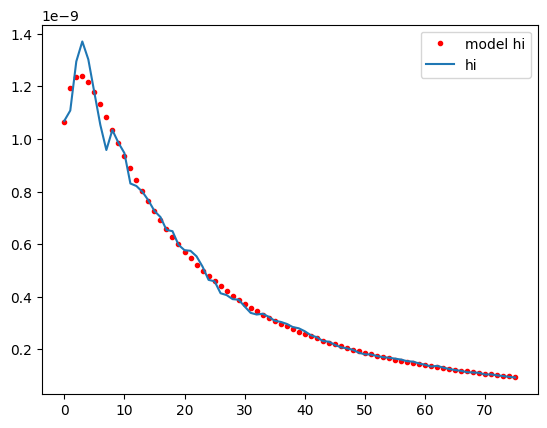

In [315]:
f0=50
plt.plot(hi_model[:,f0,f0],'r.',label='model hi')
plt.plot(hi_binned[:,f0,f0], label='hi')
plt.legend()
plt.loglog